In [15]:
# isort: skip_file
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
sys.path.append("../..")
from fishing_detection_model.model import generic_fishing_model  # noqa
from fishing_detection_model.events.extract_events import label_and_segment  # noqa

The model is setup to predict on sequences of Python dicts ("records") so after we
load the CSV using Pandas and split it into tracks, we need to pass it through
`tracks_as_records` to run prediction. This takes care of batching the predictions and
stiching them back together, although some points on the ends will not get predictions
because the model needs some context.

An example of the record format is printed below for reference.

In [17]:
track_data = pd.read_csv("../data/synthetic_tracks.csv")
track_data["timestamp"] = pd.to_datetime(track_data.timestamp)
tracks = [track_data[track_data.id == id_] for id_ in track_data.id.unique()]


def track_as_records(track):
    return [x._asdict() for x in track.itertuples(index=False)]


track_as_records(tracks[0])[0]

{'id': 0,
 'timestamp': Timestamp('2020-01-01 00:00:00'),
 'lat': -66.75517775196516,
 'lon': 164.81384018928554,
 'course_degrees': 296.8651040545398,
 'speed_knots': 0.0}

Load the model. `GenericFishingModel` is designed to support multiple models and metadata about how to treat
inputs and outputs are embedded in the HDF5 file that the weights are packaged in.

In [18]:
mdl = generic_fishing_model.GenericFishingModel.load_model(
    "../data/untracked/fishing_model_attn6_v20211027.hdf5"
)

Infer behavior for a track and plot it. We trim the track length here to make the plot less busy.

17/17 [==============================] - 1s 14ms/step


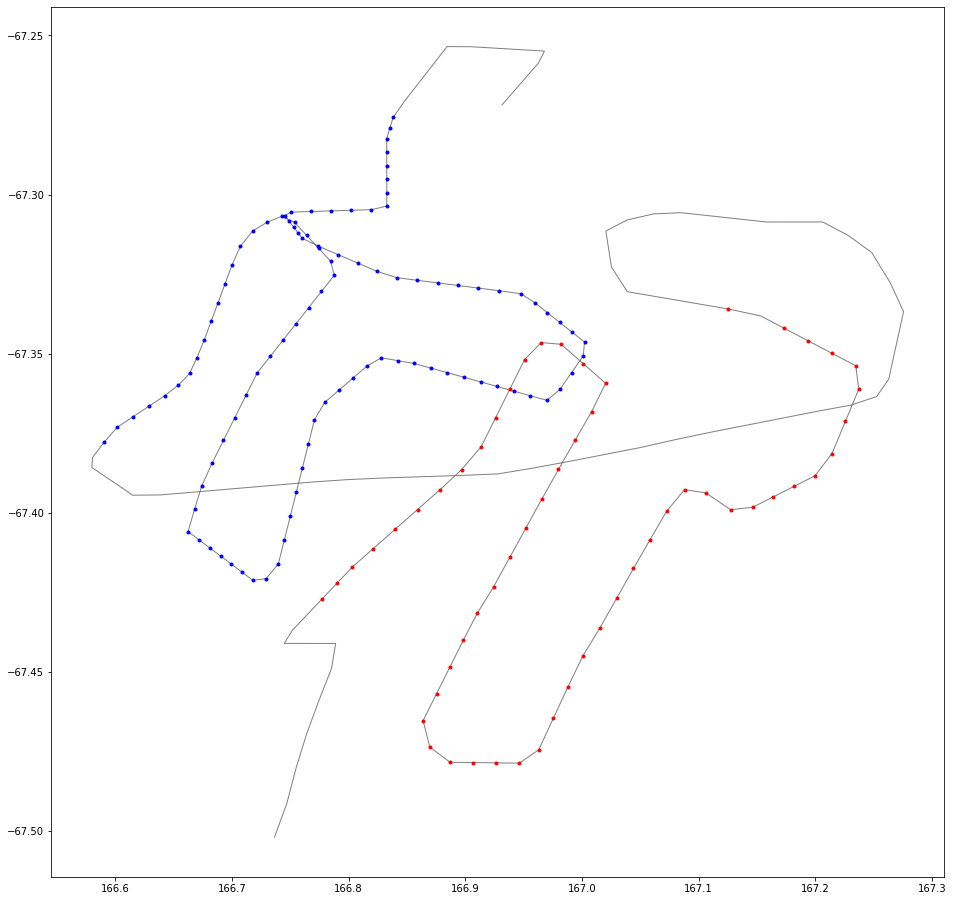

In [19]:
categories = ["other", "setting", "hauling"]


def run_inference(track):
    records, scores = mdl.predict_from_records(track_as_records(track))
    timestamp = np.array([x["timestamp"] for x in records])
    id_ = np.array([str(x["id"]) for x in records])
    lon = np.array([x["lon"] for x in records])
    lat = np.array([x["lat"] for x in records])
    category_no = np.argmax(scores, axis=1)
    score = scores.max(axis=1)
    category = [categories[i] for i in category_no]
    return pd.DataFrame(
        {
            "id": id_,
            "timestamp": timestamp,
            "lon": lon,
            "lat": lat,
            "category": category,
            "score": score,
        }
    ).astype({"timestamp": object})


def show_raw(df):
    plt.figure(figsize=(16, 16))
    setting = df.category == "setting"
    hauling = df.category == "hauling"
    plt.plot(df.lon, df.lat, linewidth=1.0, color="gray")
    plt.plot(df.lon[setting], df.lat[setting], "r.", linewidth=1.0)
    plt.plot(df.lon[hauling], df.lat[hauling], "b.", linewidth=1.0)


labeled_track_0 = run_inference(tracks[0])
show_raw(labeled_track_0.iloc[:230])

We can process this further by extracting setting and hauling events from the tracks.

In [20]:
segments_0 = list(label_and_segment(labeled_track_0, categories))

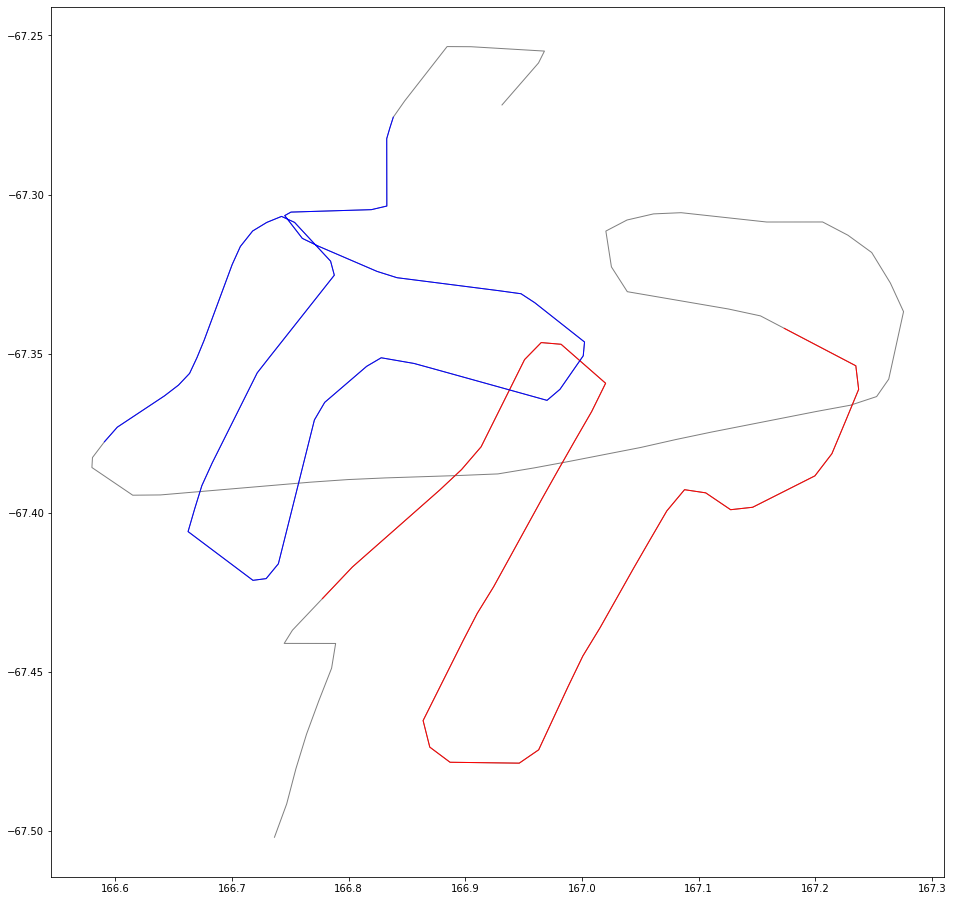

In [21]:
def show_segments(df, segments):
    plt.figure(figsize=(16, 16))
    plt.plot(df.lon, df.lat, linewidth=1.0, color="gray")
    colors = {"setting": "red", "hauling": "blue"}
    for seg in segments:
        if seg["label"] not in colors:
            continue
        mask = (df.timestamp >= seg["start_time"]) & (df.timestamp <= seg["end_time"])
        plt.plot(df.lon[mask], df.lat[mask], color=colors[seg["label"]], linewidth=1.0)


show_segments(labeled_track_0.iloc[:230], segments_0)